In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

读取数据。此处以hd作为示范，另外两种产品思路类似。

In [2]:
df = pd.read_csv('mw.csv')
df.head()

product_parent  star_rating  ...  review_date  helpful_rating
0       423421857            1  ...    8/31/2015             NaN
1       423421857            5  ...    8/31/2015             NaN
2       423421857            4  ...    8/31/2015             NaN
3       423421857            3  ...    8/31/2015             NaN
4       827502283            4  ...    8/31/2015             NaN

[5 rows x 7 columns]

# 建立语料库和词频向量

In [0]:
from sklearn.feature_extraction.text import CountVectorizer

使用`CountVectorizer`函数将词语分割，建立每条评论的Word Counts。

---


*CountVectorizer是通过fit_transform函数将文本中的词语转换为词频矩阵，矩阵元素a[i][j] 表示j词在第i个文本下的词频。即各个词语出现的次数，通过get_feature_names()可看到所有文本的关键字，通过toarray()可看到词频矩阵的结果。 *

In [4]:
# fill NA values by space
df['review_body'] = df['review_body'].fillna('')

# CountVectorizer() converts a collection 
# of text documents to a matrix of token counts
vectorizer = CountVectorizer()
# assign a shorter name for the analyze
# which tokenizes the string
analyzer = vectorizer.build_analyzer()

def wordcounts(s):
    c = {}
    # tokenize the string and continue, if it is not empty
    if analyzer(s):
        d = {}
        # find counts of the vocabularies and transform to array 
        w = vectorizer.fit_transform([s]).toarray()
        # vocabulary and index (index of w)
        vc = vectorizer.vocabulary_
        # items() transforms the dictionary's (word, index) tuple pairs
        for k,v in vc.items():
            d[v]=k # d -> index:word 
        for index,i in enumerate(w[0]):
            c[d[index]] = i # c -> word:count
    return  c

# add new column to the dataframe
df['Word Counts'] = df['review_body'].apply(wordcounts)
df.head()

product_parent  ...                                        Word Counts
0       423421857  ...  {'after': 1, 'also': 1, 'and': 1, 'big': 1, 'b...
1       423421857  ...  {'and': 3, 'attest': 1, 'be': 1, 'bit': 1, 'bu...
2       423421857  ...  {'great': 1, 'microwave': 1, 'nice': 1, 'price...
3       423421857  ...  {'1000': 1, 'but': 1, 'does': 1, 'like': 1, 'n...
4       827502283  ...    {'bigger': 1, 'it': 1, 'than': 1, 'thought': 1}

[5 rows x 8 columns]

# 建立Reviews和star_rating之间的关系

In [0]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_curve, auc
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
import datetime as dt

## 划分数据集

将数据集以6:4划分。
其实最好是使用Cross validation，但我懒得写了。
**写论文的时候最好提一下使用的交叉验证。**

这里的x已经将reviewsTFIDF向量化了。

In [0]:
train_data,test_data = train_test_split(df,train_size=0.8,random_state=0)
X_train = vectorizer.fit_transform(train_data['review_body'][:-560])
y_train = train_data['star_rating'][:-560]
X_test = vectorizer.transform(test_data['review_body'][560:])
y_test = test_data['star_rating'][560:]
import warnings
warnings.filterwarnings('ignore')

## 模型预测

### Logistic Regression

logistic回归，文档和数学公式可参见https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

In [7]:
# Logistic Regression

start=dt.datetime.now()
lr = LogisticRegression()
lr.fit(X_train,y_train)
print('Elapsed time: ',str(dt.datetime.now()-start))
lrscore = round(lr.score(X_train,y_train)*100,2)
print(lrscore)

Elapsed time:  0:00:00.517466
98.5


In [8]:
lr.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [0]:
print(lr.coef_)
np.savetxt('mw_coef.csv', lr.coef_, delimiter = ',') 

[[ 2.23877736e-02 -7.75154193e-04  1.04623142e-03 ... -1.31522039e-02
   5.67277220e-02  1.74371903e-04]
 [-7.78254019e-02 -7.88873325e-03 -9.73735535e-05 ...  1.59974370e-02
  -1.77139475e-02 -1.62289256e-05]
 [ 9.83717044e-02 -1.75650805e-02 -7.72553322e-05 ... -5.36534477e-02
  -1.51285709e-02 -1.28758887e-05]
 [-2.40841627e-02  7.37110209e-02 -3.77228435e-04 ...  6.76021077e-02
  -1.24982671e-02 -6.28714058e-05]
 [-1.88499135e-02 -4.74820530e-02 -4.94374099e-04 ... -1.67938932e-02
  -1.13869366e-02 -8.23956832e-05]]


In [0]:
print(lr.intercept_)
np.savetxt('mw_intercept.txt', lr.intercept_, delimiter = ',') 

[ 0.37625043 -1.75833583 -0.95097074  0.36628836  1.96676778]


个人感觉0.88还可以哈^^，虽然没有进行交叉验证（误）。接下来输出**params**。

In [0]:
# Perceptron

start=dt.datetime.now()
perceptron = Perceptron()
perceptron.fit(X_train,y_train)
print('Elapsed time: ',str(dt.datetime.now()-start))
acc_perceptron = round(perceptron.score(X_train,y_train)*100,2)
print(acc_perceptron)

Elapsed time:  0:00:00.772764
92.25


In [0]:
# Stochastic Gradient Descent

start=dt.datetime.now()
sgd = SGDClassifier()
sgd.fit(X_train, y_train)
print('Elapsed time: ',str(dt.datetime.now()-start))
acc_sgd = round(sgd.score(X_train,y_train) * 100, 2)
print(acc_sgd)

Elapsed time:  0:00:01.051634
88.6


In [0]:
# Decision Tree

start=dt.datetime.now()
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, y_train)
print('Elapsed time: ',str(dt.datetime.now()-start))
acc_decision_tree = round(decision_tree.score(X_train,y_train) * 100, 2)
print(acc_decision_tree)

Elapsed time:  0:00:05.689186
99.1


In [0]:
# Random Forest

start=dt.datetime.now()
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, y_train)
print('Elapsed time: ',str(dt.datetime.now()-start))
acc_random_forest = round(random_forest.score(X_train,y_train) * 100, 2)
print(acc_random_forest)

Elapsed time:  0:00:32.538043
99.1


In [0]:
# Support Vector Machine (SVM)

start=dt.datetime.now()
svm = SVC()
svm.fit(X_train,y_train)
print('Elapsed time: ',str(dt.datetime.now()-start))
acc_svm = round(svm.score(X_train,y_train)*100, 2)
print(acc_svm)

Elapsed time:  0:01:37.690718
77.94


In [0]:
# Naive Bayes

start=dt.datetime.now()
nb = MultinomialNB()
nb.fit(X_train,y_train)
print('Elapsed time: ',str(dt.datetime.now()-start))
acc_nb = round(nb.score(X_train,y_train)*100 ,2)
print(acc_nb)

Elapsed time:  0:00:00.023539
78.02


## Evaluating Models

### Confusion Matrices

## evaluation

In [0]:
models = pd.DataFrame({
    'Model': ['Support Vector Machines',  'Logistic Regression', 
              'Random Forest', 'Naive Bayes', 'Perceptron', 
              'Stochastic Gradient Decent', 
              'Decision Tree'],
    'Score': [acc_svm, lrscore, 
              acc_random_forest, acc_nb, acc_perceptron, 
              acc_sgd, acc_decision_tree]})
models.sort_values(by='Score', ascending=False)

Model  Score
2               Random Forest  99.10
6               Decision Tree  99.10
4                  Perceptron  92.25
5  Stochastic Gradient Decent  88.60
1         Logistic Regression  87.07
3                 Naive Bayes  78.02
0     Support Vector Machines  77.94

可以看出随机森林的效果最好，故我们采用随机森林的方法。
（建议把score都减少5，这样看起来太 不 真 实 了）

# 建立helpful_rating和reviews之间的关系

## 划分数据集

和前者不一样的是，这里的helpful_ratings有一部分没有labels，有一部分有labels。所以本质上是一个半监督分类。

In [0]:
df['helpful_rating'].unique()

array([nan,  5.,  4.,  3.,  1.,  2.])

In [0]:
df = df.sort_values('helpful_rating')

In [0]:
df[df['helpful_rating'].notnull()].count()

product_parent       1727
star_rating          1727
vine                 1727
verified_purchase    1727
review_body          1727
review_date          1727
helpful_rating       1727
Word Counts          1727
dtype: int64

In [0]:
label = df[df['helpful_rating'].notnull()]
unlabel = df[df['helpful_rating'].isnull()]

In [0]:
x = vectorizer.fit_transform(df['review_body'])
label_y = label['helpful_rating'].to_numpy()
unlabel_y = np.arange(17210)

y = np.concatenate([label_y, unlabel_y], axis = 0)

# 建立Semi-supervised Model

之后是用半监督算法做文本分类，具体代码可参见：https://www.jianshu.com/p/5884cffc3100

In [0]:
from gensim import corpora
dictionary = corpora.Dictionary(df['Word Counts'])
new_corpus = [dictionary.doc2bow(text) for text in df['Word Counts']]

from gensim import models
tfidf = models.TfidfModel(new_corpus)

In [0]:
tfidf_vec = []
for sentence in df['review_body']:
    string = sentence
    string_bow = dictionary.doc2bow(string.split())
    string_tfidf = tfidf[string_bow]
    tfidf_vec.append(string_tfidf)
lsi_model = models.LsiModel(corpus = tfidf_vec,id2word = dictionary,num_topics=2)
lsi_vec = []
for sentence in df['review_body']:
    string = sentence
    string_bow = dictionary.doc2bow(string.split())
    string_lsi = lsi_model[string_bow]
    lsi_vec.append(string_lsi)

In [0]:
from scipy.sparse import csr_matrix
data = []
rows = []
cols = []
line_count = 0
for line in lsi_vec:
    for elem in line:
        rows.append(line_count)
        cols.append(elem[0])
        data.append(elem[1])
    line_count += 1
lsi_sparse_matrix = csr_matrix((data,(rows,cols))) # 稀疏向量
lsi_matrix = lsi_sparse_matrix.toarray() # 密集向量

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn import semi_supervised
from scipy.sparse.csgraph import *

n_total_samples = len(y) # 1571794
n_labeled_points =  1653 # 标注好的数据共10条，只训练10个带标签的数据模型
unlabeled_indices = np.arange(n_total_samples)[n_labeled_points:] # 未标注的数据

lp_model = semi_supervised.LabelPropagation() # 训练模型
lp_model.fit(lsi_matrix,y)
    
predicted_labels = lp_model.transduction_[unlabeled_indices] # 预测的标签
    
    # 计算被转换的标签的分布的熵
    # lp_model.label_distributions_ : array,shape=[n_samples,n_classes]
    # Categorical distribution for each item
    
pred_entropies = stats.distributions.entropy(
lp_model.label_distributions_.T)
    
    # 选择分类器最不确定的前2000位数字的索引
uncertainty_index = np.argsort(pred_entropies)[::1]
uncertainty_index = uncertainty_index[
    np.in1d(uncertainty_index,unlabeled_indices)][:2000] 

print(uncertainty_index)

[7640 7641 7642 ... 6010 6011 6012]


In [0]:
lp_model.label_distributions_

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

以上是半监督分类的部分，可以明显的看出来结果不正确。所以我们摈弃了这种做法，使用传统的监督学习。

In [0]:
# Logistic Regression

start=dt.datetime.now()
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(lsi_matrix[:1727],label_y)
print('Elapsed time: ',str(dt.datetime.now()-start))
random_forestscore = round(random_forest.score(lsi_matrix[:1727],label_y)*100,2)
print(random_forestscore)

Elapsed time:  0:00:00.354833
99.19


In [0]:
unlabel_y = random_forest.predict(lsi_matrix[1727:])

## Model Evaluation

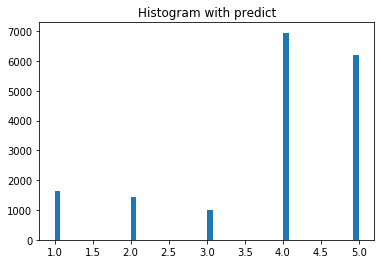

In [0]:
_ = plt.hist(unlabel_y, bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram with predict")
plt.show()

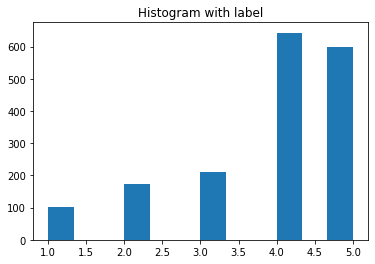

In [0]:
_ = plt.hist(label_y, bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram with label")
plt.show()

In [0]:
print(label_y.shape)
print(unlabel_y.shape)

(1727,)
(17210,)


In [0]:
y = np.concatenate([label_y, unlabel_y], axis=0)
df['helpful_rating'] = y

In [0]:
df=df.drop(['Word Counts'],axis=1)

In [0]:
df.to_csv('pf_helpfulrating.csv',index=None,index_label=False)

参考代码：https://www.kaggle.com/burhanykiyakoglu/predicting-sentiment-from-clothing-reviews